# 프로젝트: CAM을 만들고 평가해 보자

## CAM 구현하기

CAM을 직접 구현  
만든 함수로 CAM 이미지를 생성  
원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

120


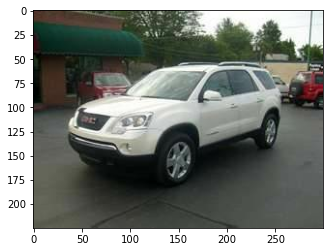

In [5]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [6]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [7]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0] 
    # opencv.resize는 height * width의 순서로 들어가는데 거기에 맞춰주면 됨 line3에 width라고 되있지만 실제 뽑힌건 shape[1]이므로 heigth, 
    # 이것을 resize에 실제 이미지의 세로*가로 형식으로 넣어줌
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output]) #input, output, name
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    # 소프트맥스 레이어의 가중치
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

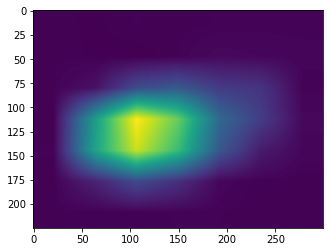

In [8]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

두개의 이미지 더하기(블랜딩)  
https://webnautes.tistory.com/1245

In [9]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
   
    return merged_image

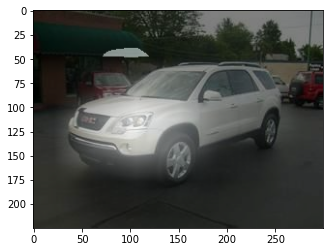

In [10]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

184


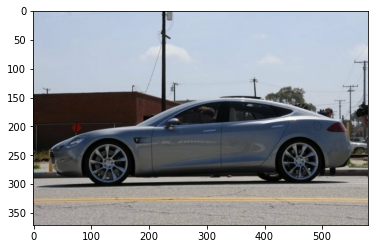

In [11]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

Grad-CAM을 직접 구현  
만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인  
위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화

In [12]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

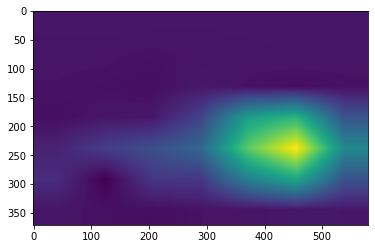

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

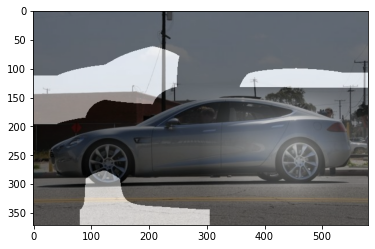

In [14]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

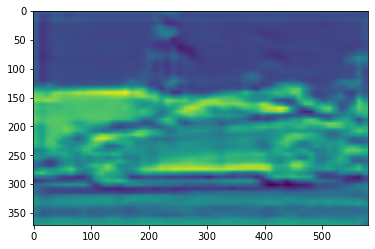

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block1_2_relu', item)
plt.imshow(grad_cam_image)

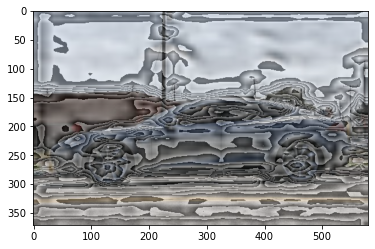

In [20]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 바운딩 박스 구하기

제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

위에서 얻은 바운딩 박스를 시각화해 보세요.

In [51]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

141


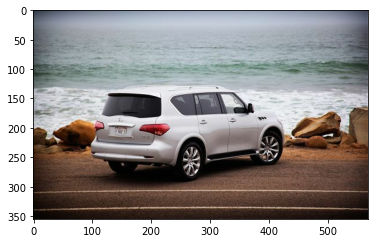

In [64]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [65]:
origin_image = item['image'].astype(np.uint8)

* cam

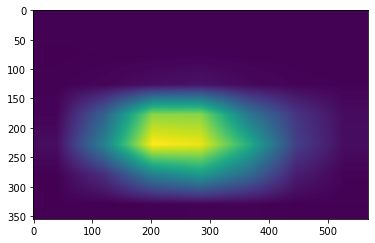

In [66]:

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [67]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 42, 320],
       [ 45, 121],
       [519, 130],
       [516, 329]])

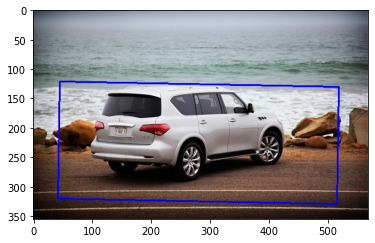

In [68]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

* grad-cam

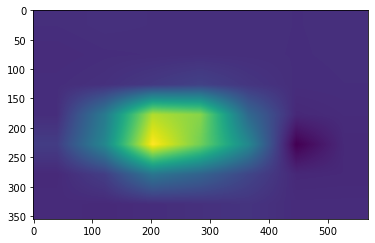

In [69]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [70]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ -1, 109],
       [425, 104],
       [427, 318],
       [  1, 323]])

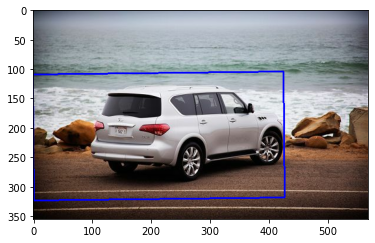

In [71]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

In [74]:
cam_image.shape, origin_image.shape

((355, 569), (355, 569, 3))

In [75]:
cam_image_3channel_1 = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
# 원본을 가져올때 /255했으니 원래대로 복원, stack은 shape가 동일해야 하니 차원수도 늘려줌?

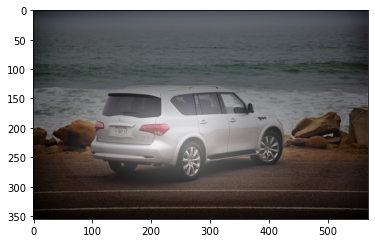

In [76]:
blended_image = visualize_cam_on_image(cam_image_3channel_1, origin_image)
plt.imshow(blended_image)

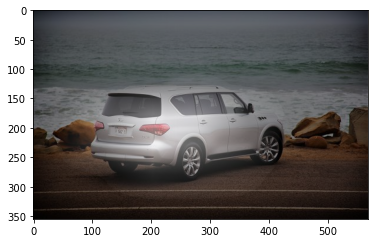

In [77]:
grad_cam_image_3channel_1 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image2 = visualize_cam_on_image(grad_cam_image_3channel_1, origin_image)
plt.imshow(blended_image2)

## IoU 구하기

 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수  
 CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교

In [42]:
# 원본의 바운딩박스
item['bbox']

array([0.35211268, 0.16695958, 0.8197183 , 0.7557118 ], dtype=float32)

In [40]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [41]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.3408450704225352,
 0.07381370826010544,
 0.9267605633802817,
 0.9121265377855887]

In [46]:
pred_grad_bbox = rect_to_minmax(grad_rect, item['image'])
pred_grad_bbox

[0.29295774647887324,
 -0.0017574692442882249,
 0.9098591549295775,
 0.7504393673110721]

In [43]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [44]:
get_iou(pred_bbox, item['bbox'])

0.5604942679559006

In [48]:
get_iou(pred_grad_bbox, item['bbox'])

0.584866784702068

GRAD_CAM이 CAM보다 차량을 더 정확히 포착하는 바운딩박스를 생성한다. 모델이 얼마나 영역을 잘 찾아냈는지를 비교하는 IOU지표상으로는 0.02 정도의 차이가 나타난다.
여러개의 사진을 반복문을 통해 작업하거나 한 화면에 나타내는 방식으로 표현하려 했으나 for문 사용시 get_one의 ds.take(1) 부분이 바뀌지 않는건지 마지막의 그래프만 나타나는 문제생김
